# Dairy Herd Analysis & Optimization

This notebook provides comprehensive analysis of dairy herd data to optimize productivity, health, and economic outcomes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
import xgboost as xgb
from joblib import dump, load
import warnings

# Set visualization style
plt.style.use('seaborn-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

/tmp/ipykernel_221962/3868243839.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Data Loading & Initial Exploration

Loading the simulation results from the parquet file and exploring the dataset structure.

In [ ]:
# Let's load the most recent simulation dataset
import glob
import os

# Find the most recent parquet file
parquet_files = glob.glob('/home/iyed/Documents/IP/realistic_herd_simulation_*.parquet')
parquet_files.sort(key=os.path.getmtime, reverse=True)

# Use the most recent file, or fall back to the specified one if no recent files found
recent_file = parquet_files[0] if parquet_files else 'herd_simulation_results8.parquet'
print(f"Loading data from: {recent_file}")
df = pd.read_parquet(recent_file)

In [4]:
df.describe()

,age,parity,dim,bcs,thi,cbt,resp_rate,scc,cooling,mastitis,...,feed_fiber,ambient_temp,ambient_rh,stress_units,bcs_milk_factor,cp_adj,day,animal_id,feed_to_milk_ratio,water_efficiency
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,6.36000,3.500000,127.770000,3.031000,59.249860,39.147315,76.301813,91.180000,0.400000,0.0,...,32.020097,16.259548,45.837720,8.591124,0.980800,0.945541,299.500000,49.500000,0.158797,0.216097
std,2.37274,1.723383,85.640524,0.296548,100.638535,4.002858,116.919557,38.059844,0.489902,0.0,...,1.961194,72.925530,18.475908,61.101260,0.036951,0.082501,173.206284,28.866311,2.433320,0.098436
min,2.00000,1.000000,5.000000,2.200000,-1106.000000,38.190000,60.000000,35.000000,0.000000,0.0,...,28.000000,-760.000000,20.000000,0.000000,0.800000,0.630000,0.000000,0.000000,-51.856000,0.050000
25%,4.47500,2.000000,52.500000,2.800000,49.700000,38.600000,60.000000,64.750000,0.000000,0.0,...,30.660000,8.100000,26.100000,0.000000,0.990000,0.900000,149.750000,24.750000,0.156125,0.147075
50%,6.70000,3.000000,121.500000,3.000000,59.400000,38.600000,60.000000,87.000000,0.000000,0.0,...,32.010000,15.500000,48.200000,0.000000,0.990000,0.970000,299.500000,49.500000,0.243087,0.224100
75%,8.32500,5.000000,187.250000,3.225000,67.600000,38.600000,60.000000,107.750000,1.000000,0.0,...,33.350000,22.500000,63.900000,0.000000,1.000000,1.000000,449.250000,74.250000,0.435571,0.282000
max,10.00000,6.000000,300.000000,3.600000,898.100000,99.550000,1792.000000,288.000000,1.000000,0.0,...,40.000000,598.100000,70.000000,824.780000,1.000000,1.170000,599.000000,99.000000,2.214000,0.499000


In [5]:
df.columns

Index(['breed', 'age', 'parity', 'dim', 'bcs', 'thi', 'cbt', 'resp_rate',
       'scc', 'cooling', 'housing', 'mastitis', 'mastitis_clinical',
       'mastitis_quarters', 'body_weight', 'dmi_kg', 'cp_intake', 'ndf_intake',
       'fat_intake', 'milk_kg', 'milk_fat_pct', 'milk_protein_pct',
       'energy_balance', 'feed_fat', 'feed_protein', 'feed_fiber',
       'ambient_temp', 'ambient_rh', 'stress_units', 'bcs_milk_factor',
       'cp_adj', 'sim_id', 'day', 'animal_id', 'feed_to_milk_ratio',
       'water_efficiency'],
      dtype='object')

In [6]:
# Basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum())

# Sample data
df.head()

Dataset shape: (60000, 36)

Missing values:
breed                 0
age                   0
parity                0
dim                   0
bcs                   0
thi                   0
cbt                   0
resp_rate             0
scc                   0
cooling               0
housing               0
mastitis              0
mastitis_clinical     0
mastitis_quarters     0
body_weight           0
dmi_kg                0
cp_intake             0
ndf_intake            0
fat_intake            0
milk_kg               0
milk_fat_pct          0
milk_protein_pct      0
energy_balance        0
feed_fat              0
feed_protein          0
feed_fiber            0
ambient_temp          0
ambient_rh            0
stress_units          0
bcs_milk_factor       0
cp_adj                0
sim_id                0
day                   0
animal_id             0
feed_to_milk_ratio    0
water_efficiency      0
dtype: int64


,breed,age,parity,dim,bcs,thi,cbt,resp_rate,scc,cooling,...,ambient_temp,ambient_rh,stress_units,bcs_milk_factor,cp_adj,sim_id,day,animal_id,feed_to_milk_ratio,water_efficiency
0,Friesian,6.0,1,93,3.3,47.3,38.6,60.0,45,0,...,5.5,40.0,0.0,0.99,0.98,20250505_1654,0,0,0.184336,0.3575
1,Friesian,9.3,3,17,3.5,47.7,38.6,60.0,62,1,...,5.9,40.0,0.0,0.91,0.80,20250505_1654,0,1,1.136471,0.0850
2,Brown Swiss,6.7,3,20,3.2,46.0,38.6,60.0,165,0,...,4.5,40.0,0.0,1.00,1.01,20250505_1654,0,2,0.210109,0.3403
3,Brown Swiss,8.8,6,78,2.9,52.3,38.6,60.0,81,1,...,9.7,40.0,0.0,1.00,0.95,20250505_1654,0,3,0.657102,0.1394
4,Friesian,4.7,2,176,2.7,43.7,38.6,60.0,125,1,...,2.6,40.0,0.0,0.99,0.95,20250505_1654,0,4,0.160537,0.3127


## 1. Productivity & Milk Yield Optimization

Analyzing factors that impact milk production and composition to optimize yield and quality.

In [7]:
# Correlation between feed intake and milk production
milk_factors = ['milk_kg', 'milk_fat_pct', 'milk_protein_pct', 'dmi_kg', 'cp_intake', 'ndf_intake', 'feed_fat', 'feed_protein', 'dim', 'breed']
milk_corr = df[milk_factors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(milk_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix: Milk Production Factors')
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'Friesian'

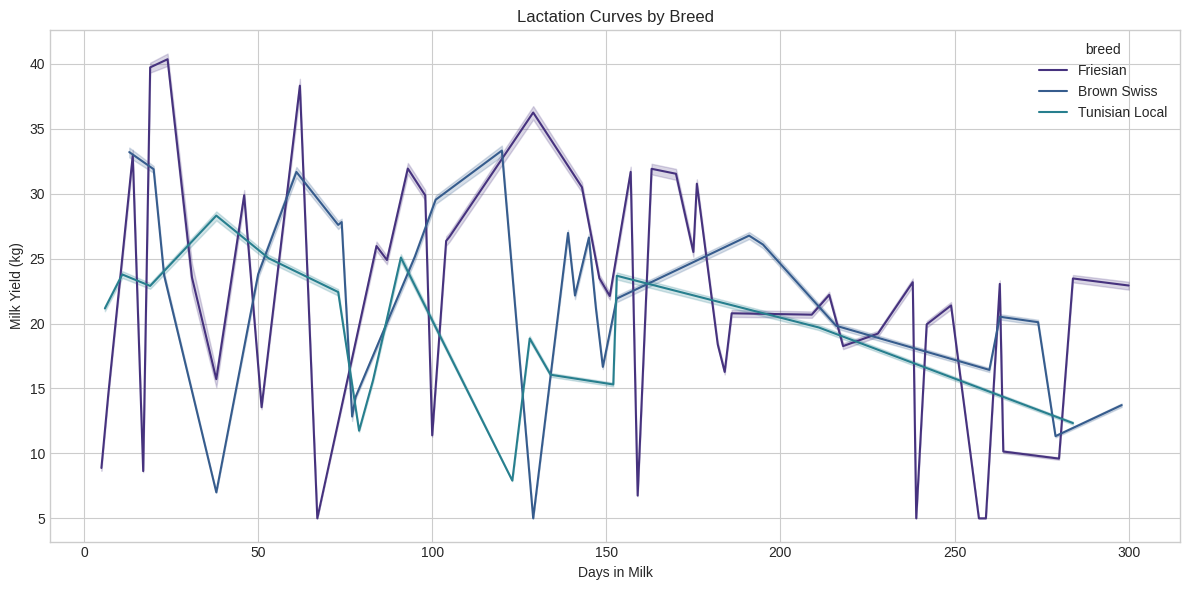

In [8]:
# Milk yield by breed and days in milk (lactation curve)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='dim', y='milk_kg', hue='breed')
plt.title('Lactation Curves by Breed')
plt.xlabel('Days in Milk')
plt.ylabel('Milk Yield (kg)')
plt.tight_layout()
plt.show()

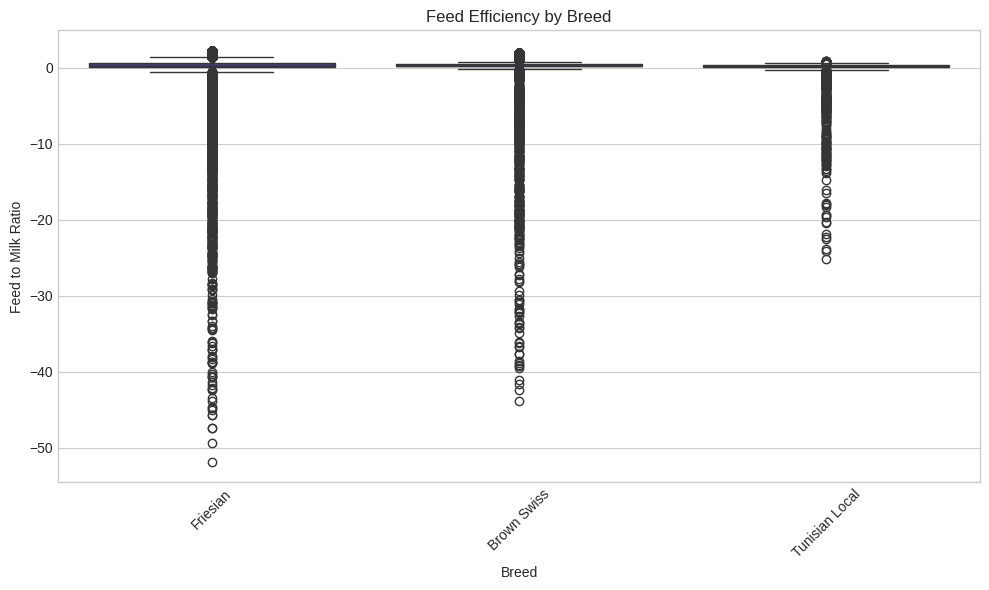

Top 10 Most Feed-Efficient Cows:


,animal_id,breed,parity,feed_to_milk_ratio,milk_kg,dmi_kg
49597,97,Friesian,6,-51.856,5.0,-259.28
49538,38,Friesian,6,-49.430,5.0,-247.15
49576,76,Friesian,5,-47.448,5.0,-237.24
49592,92,Friesian,6,-47.330,5.0,-236.65
49570,70,Friesian,6,-45.672,5.0,-228.36
49501,1,Friesian,3,-45.664,5.0,-228.32
49586,86,Friesian,3,-45.004,5.0,-225.02
49537,37,Friesian,2,-44.802,5.0,-224.01
49509,9,Friesian,3,-44.600,5.0,-223.00
49529,29,Brown Swiss,4,-43.844,5.0,-219.22


In [9]:
# Feed efficiency analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='breed', y='feed_to_milk_ratio')
plt.title('Feed Efficiency by Breed')
plt.xlabel('Breed')
plt.ylabel('Feed to Milk Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify most efficient cows
top_efficient = df.sort_values('feed_to_milk_ratio').head(10)
print("Top 10 Most Feed-Efficient Cows:")
display(top_efficient[['animal_id', 'breed', 'parity', 'feed_to_milk_ratio', 'milk_kg', 'dmi_kg']])

## 2. Health & Disease Management

Predicting and preventing health issues, particularly mastitis, through data analysis.

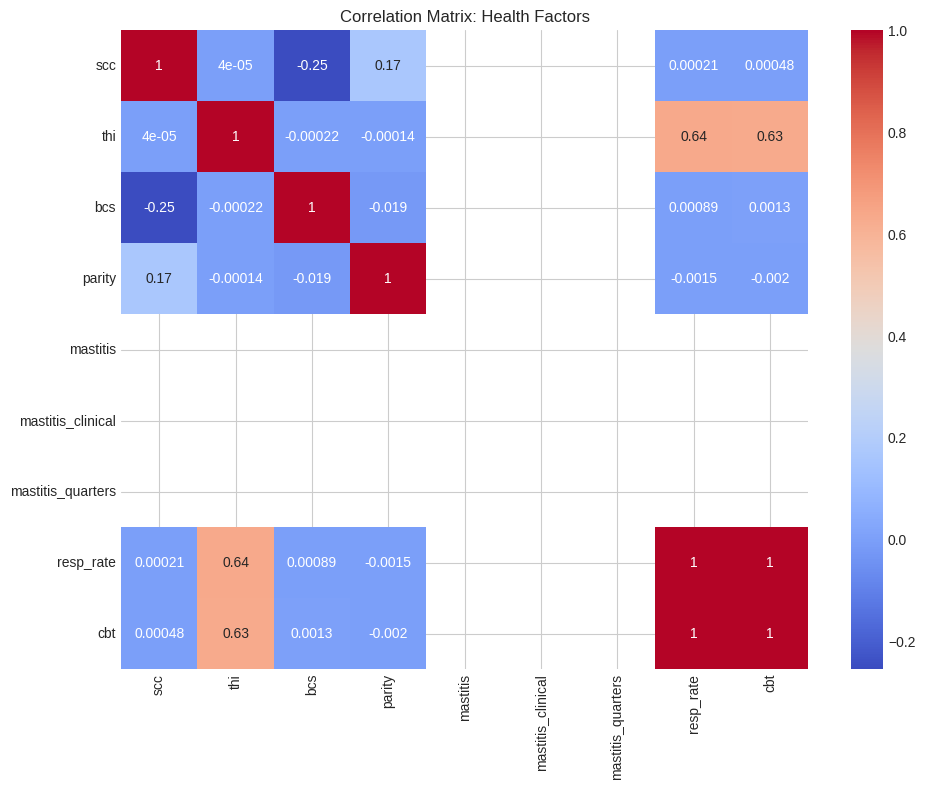

In [10]:
# Mastitis risk factors analysis
health_factors = ['scc', 'thi', 'bcs', 'parity', 'mastitis', 'mastitis_clinical', 'mastitis_quarters', 'resp_rate', 'cbt']
health_df = df[health_factors]

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(health_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Health Factors')
plt.tight_layout()
plt.show()

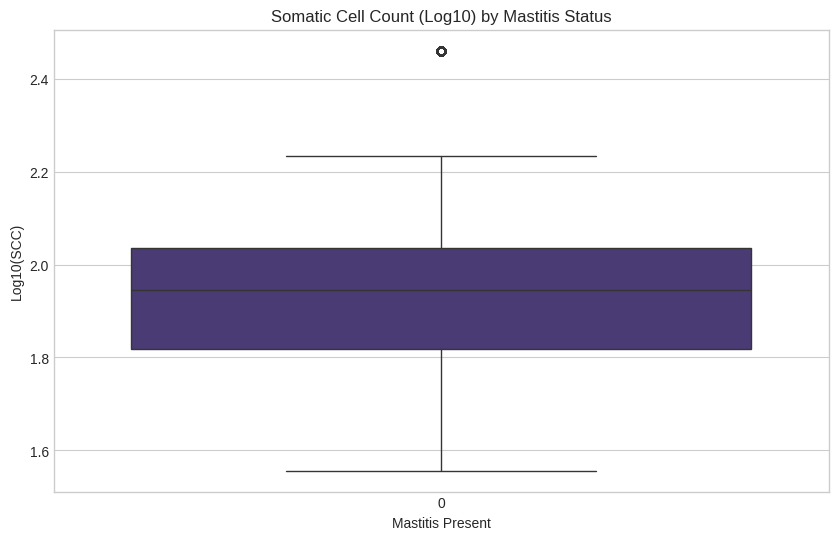

Percentage of mastitis cases that are clinical: nan%


In [11]:
# SCC thresholds and mastitis
plt.figure(figsize=(10, 6))
df['scc_log'] = np.log10(df['scc'] + 1)  # Log transformation for better visualization

sns.boxplot(x='mastitis', y='scc_log', data=df)
plt.title('Somatic Cell Count (Log10) by Mastitis Status')
plt.xlabel('Mastitis Present')
plt.ylabel('Log10(SCC)')
plt.show()

# Clinical vs subclinical mastitis
mastitis_df = df[df['mastitis'] == 1]
clinical_pct = 100 * mastitis_df['mastitis_clinical'].mean()
print(f"Percentage of mastitis cases that are clinical: {clinical_pct:.2f}%")

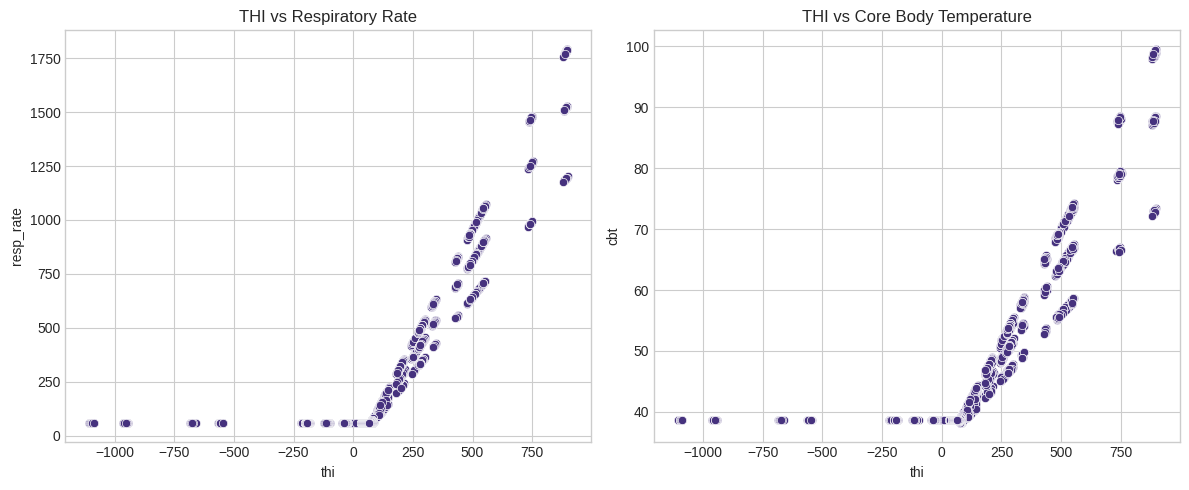

Respiratory Rate prediction from THI:
R² score: 0.4048
Formula: resp_rate = 32.51 + 0.74 × THI


In [12]:
# Heat stress impact on health
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='thi', y='resp_rate')
plt.title('THI vs Respiratory Rate')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='thi', y='cbt')
plt.title('THI vs Core Body Temperature')
plt.tight_layout()
plt.show()

# Simple linear model to predict resp_rate from THI
X = df[['thi']].values
y = df['resp_rate'].values
model = LinearRegression().fit(X, y)
print(f"Respiratory Rate prediction from THI:")
print(f"R² score: {model.score(X, y):.4f}")
print(f"Formula: resp_rate = {model.intercept_:.2f} + {model.coef_[0]:.2f} × THI")

## 3. Nutritional Strategies

Optimizing feed composition and intake to maximize production and health outcomes.

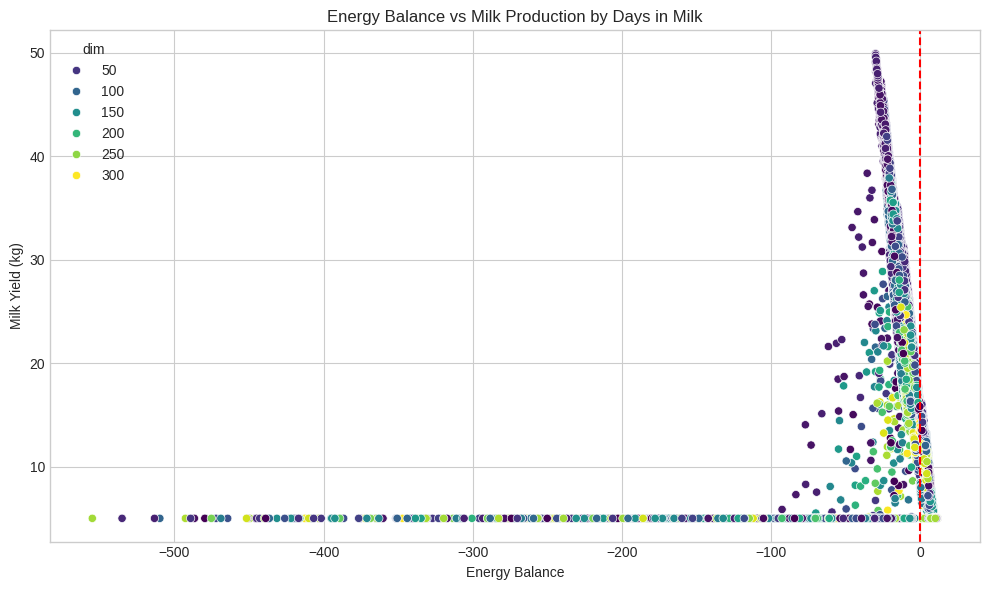

In [13]:
# Relationship between energy balance and milk production
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='energy_balance', y='milk_kg', hue='dim', palette='viridis')
plt.title('Energy Balance vs Milk Production by Days in Milk')
plt.xlabel('Energy Balance')
plt.ylabel('Milk Yield (kg)')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

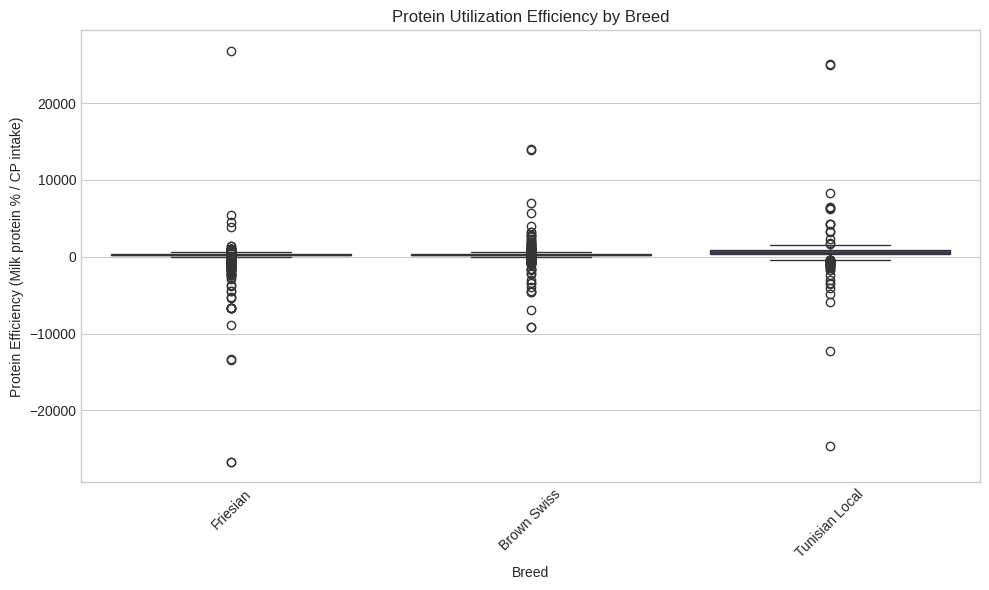

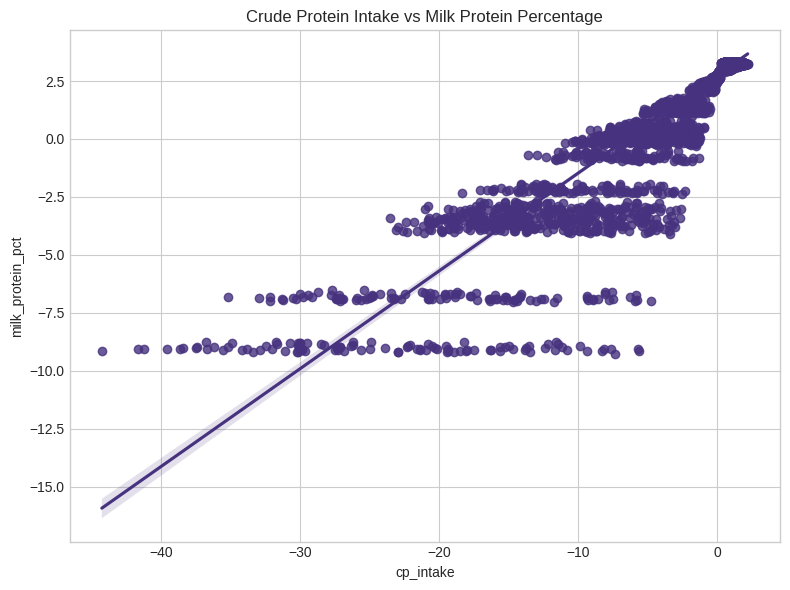

In [14]:
# Protein utilization efficiency
df['protein_efficiency'] = df['milk_protein_pct'] / df['cp_intake'] * 100

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='breed', y='protein_efficiency')
plt.title('Protein Utilization Efficiency by Breed')
plt.xlabel('Breed')
plt.ylabel('Protein Efficiency (Milk protein % / CP intake)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Relationship between crude protein intake and milk protein
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='cp_intake', y='milk_protein_pct')
plt.title('Crude Protein Intake vs Milk Protein Percentage')
plt.tight_layout()
plt.show()

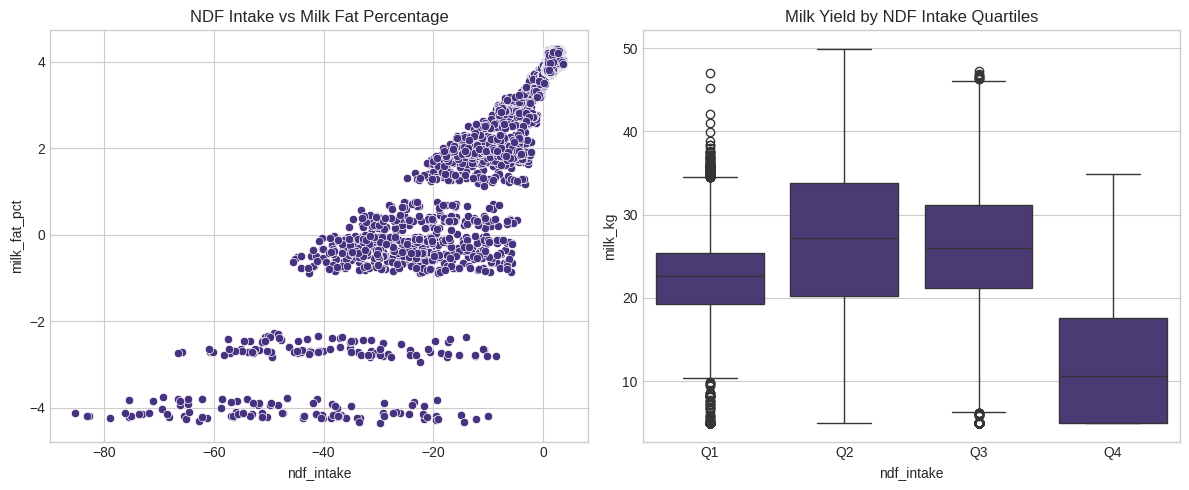

In [15]:
# NDF impact on production and health
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='ndf_intake', y='milk_fat_pct')
plt.title('NDF Intake vs Milk Fat Percentage')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=pd.qcut(df['ndf_intake'], 4, labels=["Q1", "Q2", "Q3", "Q4"]), y='milk_kg')
plt.title('Milk Yield by NDF Intake Quartiles')
plt.tight_layout()
plt.show()

## 4. Environmental & Housing Impact

Analyzing how environment and housing affect cow performance and health.

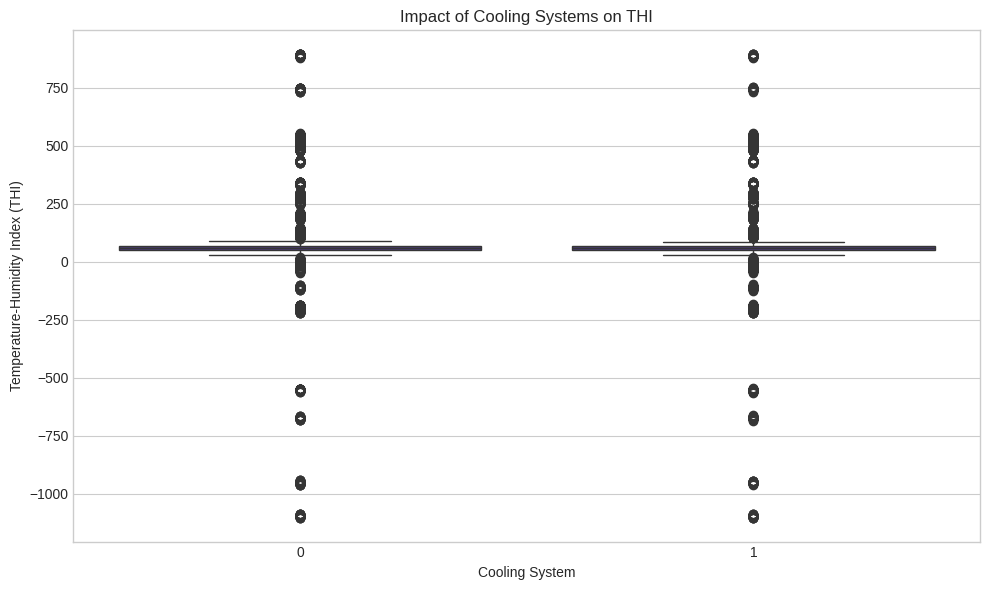

,stress_units,milk_kg,resp_rate
cooling,,,
0,8.595866,21.372934,76.268783
1,8.584010,21.964868,76.351358


In [16]:
# Cooling system effectiveness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cooling', y='thi')
plt.title('Impact of Cooling Systems on THI')
plt.xlabel('Cooling System')
plt.ylabel('Temperature-Humidity Index (THI)')
plt.tight_layout()
plt.show()

# Cooling impact on stress and milk production
cooling_impact = df.groupby('cooling').agg({'stress_units': 'mean', 'milk_kg': 'mean', 'resp_rate': 'mean'})
display(cooling_impact)

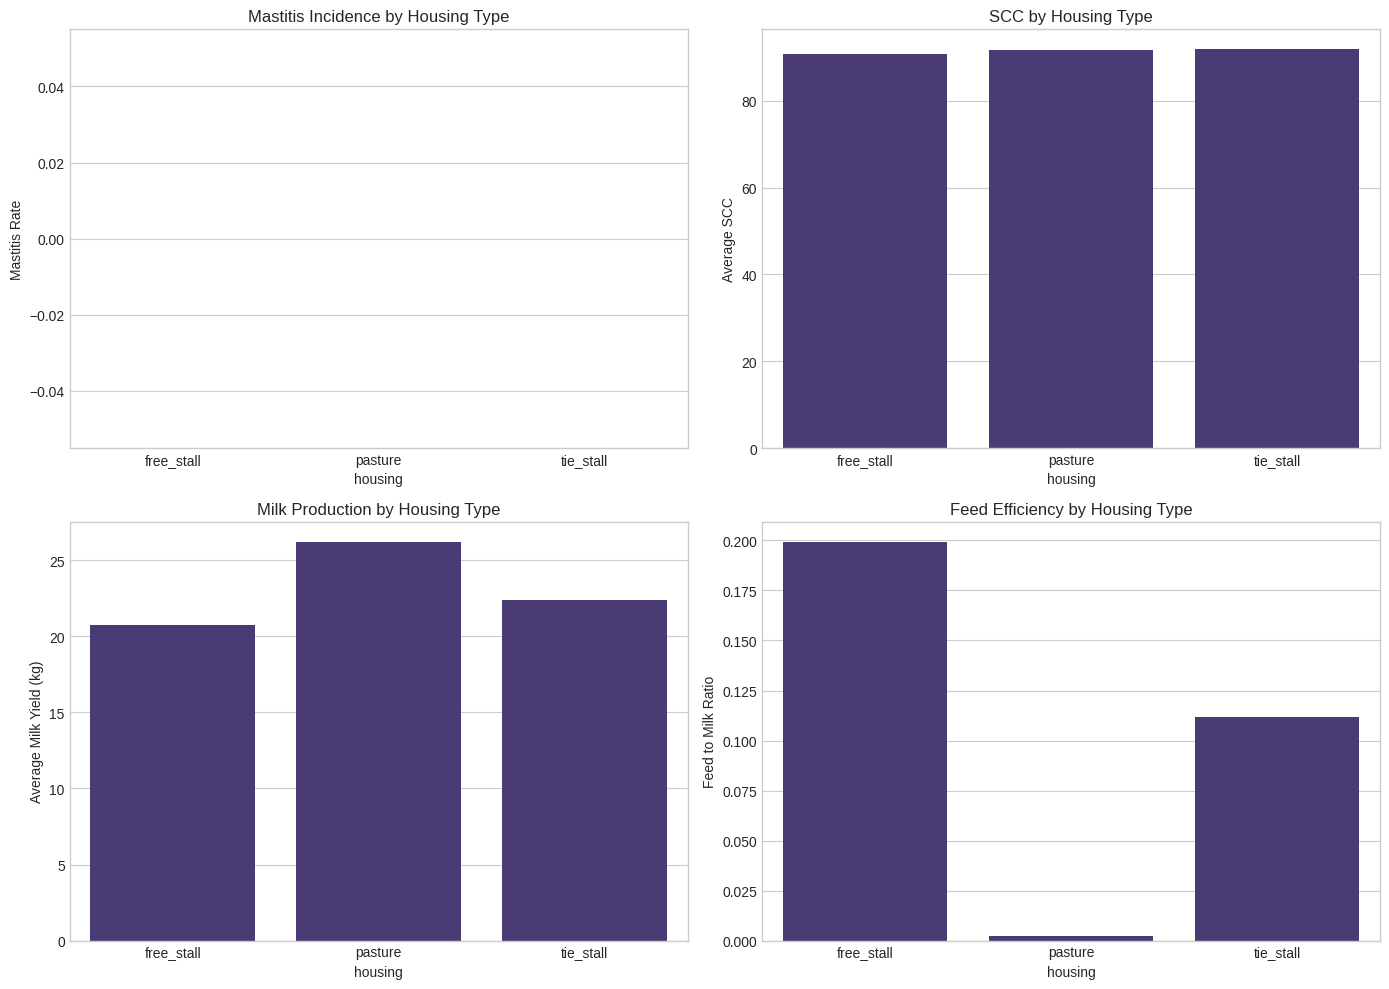

In [17]:
# Housing type effects on health and production
housing_impact = df.groupby('housing').agg({
    'mastitis': 'mean', 
    'scc': 'mean', 
    'milk_kg': 'mean',
    'feed_to_milk_ratio': 'mean',
    'resp_rate': 'mean'
}).reset_index()

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=housing_impact, x='housing', y='mastitis', ax=axes[0, 0])
axes[0, 0].set_title('Mastitis Incidence by Housing Type')
axes[0, 0].set_ylabel('Mastitis Rate')

sns.barplot(data=housing_impact, x='housing', y='scc', ax=axes[0, 1])
axes[0, 1].set_title('SCC by Housing Type')
axes[0, 1].set_ylabel('Average SCC')

sns.barplot(data=housing_impact, x='housing', y='milk_kg', ax=axes[1, 0])
axes[1, 0].set_title('Milk Production by Housing Type')
axes[1, 0].set_ylabel('Average Milk Yield (kg)')

sns.barplot(data=housing_impact, x='housing', y='feed_to_milk_ratio', ax=axes[1, 1])
axes[1, 1].set_title('Feed Efficiency by Housing Type')
axes[1, 1].set_ylabel('Feed to Milk Ratio')

plt.tight_layout()
plt.show()

## 5. Animal Welfare & Longevity

Evaluating factors that contribute to cow welfare, comfort, and productive lifespan.

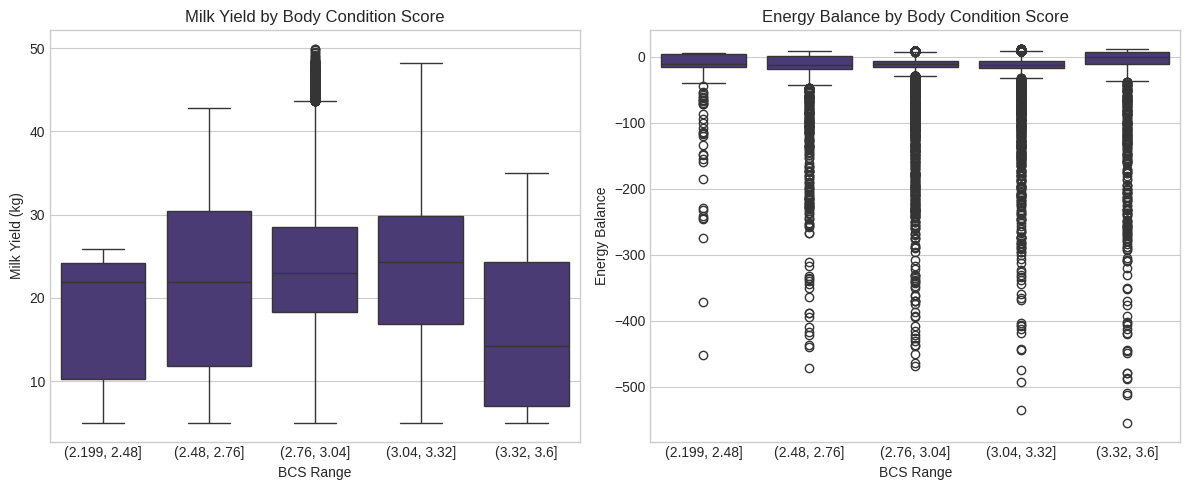

In [18]:
# Body condition score impact
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x=pd.cut(df['bcs'], bins=5), y='milk_kg')
plt.title('Milk Yield by Body Condition Score')
plt.xlabel('BCS Range')
plt.ylabel('Milk Yield (kg)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=pd.cut(df['bcs'], bins=5), y='energy_balance')
plt.title('Energy Balance by Body Condition Score')
plt.xlabel('BCS Range')
plt.ylabel('Energy Balance')

plt.tight_layout()
plt.show()

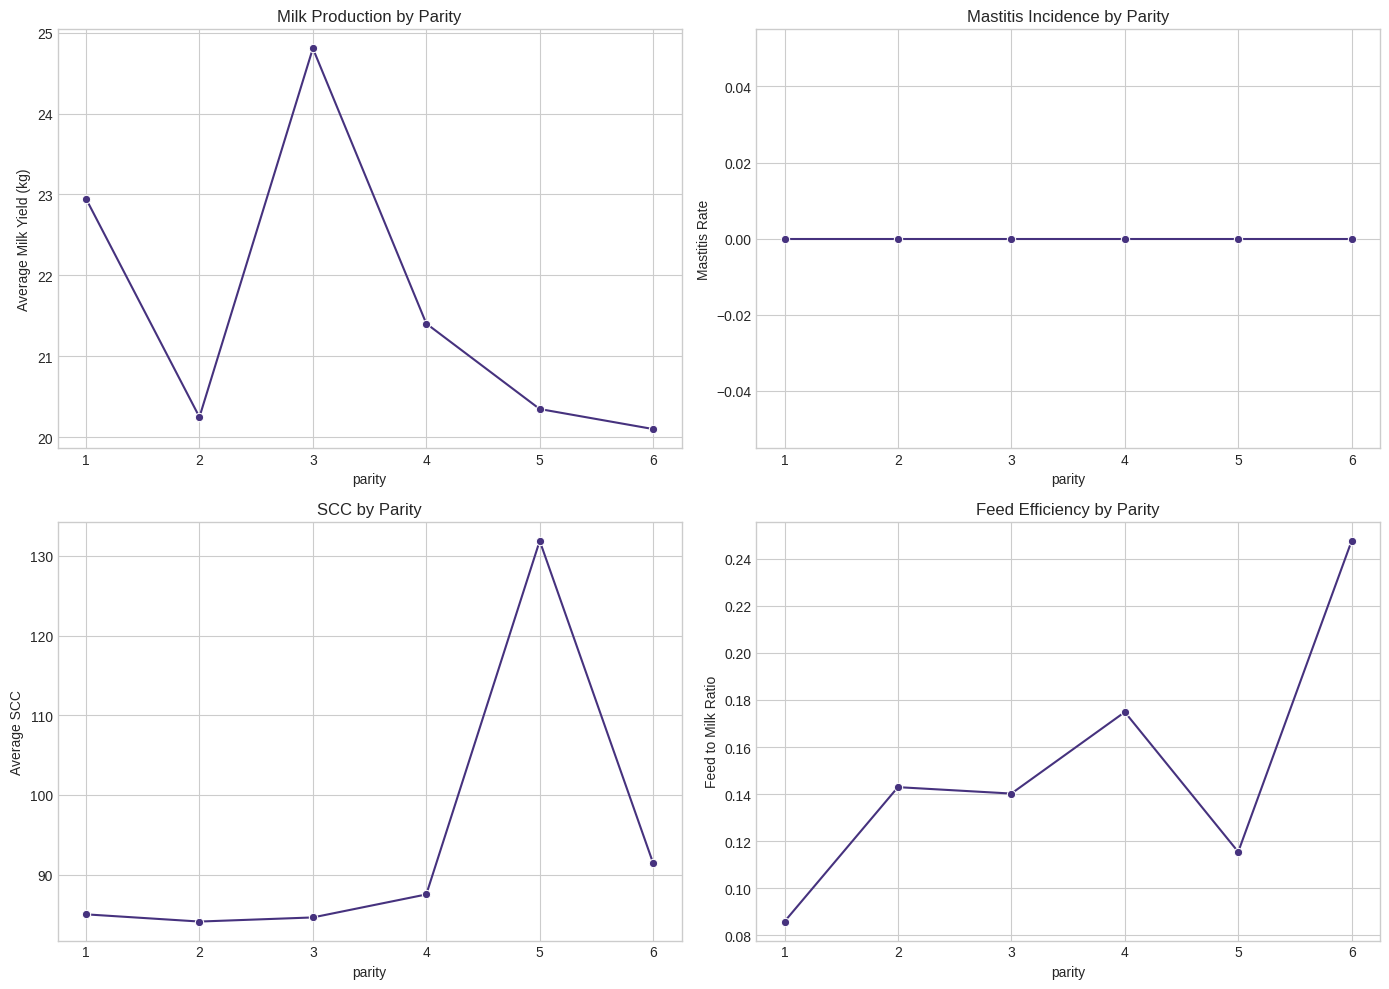

In [19]:
# Parity effects on production and health
parity_effects = df.groupby('parity').agg({
    'milk_kg': 'mean',
    'mastitis': 'mean',
    'scc': 'mean',
    'feed_to_milk_ratio': 'mean'
}).reset_index()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.lineplot(data=parity_effects, x='parity', y='milk_kg', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Milk Production by Parity')
axes[0, 0].set_ylabel('Average Milk Yield (kg)')

sns.lineplot(data=parity_effects, x='parity', y='mastitis', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Mastitis Incidence by Parity')
axes[0, 1].set_ylabel('Mastitis Rate')

sns.lineplot(data=parity_effects, x='parity', y='scc', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('SCC by Parity')
axes[1, 0].set_ylabel('Average SCC')

sns.lineplot(data=parity_effects, x='parity', y='feed_to_milk_ratio', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Feed Efficiency by Parity')
axes[1, 1].set_ylabel('Feed to Milk Ratio')

plt.tight_layout()
plt.show()

## 6. Economic & Sustainability Analysis

Evaluating the economic and environmental impact of different management strategies.

,daily_profit,milk_revenue,feed_cost,water_cost
breed,,,,
Brown Swiss,8.332341,10.033720,1.501379,0.2
Friesian,8.087817,9.844279,1.556462,0.2
Tunisian Local,7.716454,8.715957,0.799503,0.2


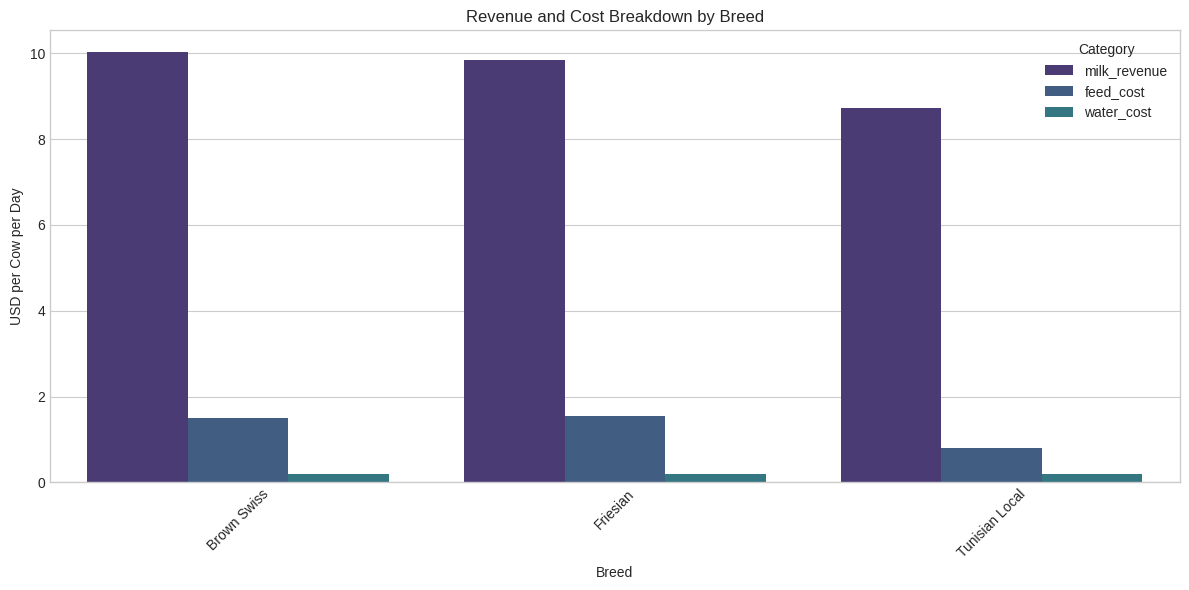

In [20]:
# Economic simulation parameters
milk_price_per_kg = 0.45  # USD/kg milk
feed_cost_per_kg = 0.30   # USD/kg dry matter
water_cost_per_liter = 0.002  # USD/liter

# Calculate profitability
df['milk_revenue'] = df['milk_kg'] * milk_price_per_kg
df['feed_cost'] = df['dmi_kg'] * feed_cost_per_kg
df['estimated_water_consumption'] = df['milk_kg'] / df['water_efficiency']
df['water_cost'] = df['estimated_water_consumption'] * water_cost_per_liter
df['daily_profit'] = df['milk_revenue'] - df['feed_cost'] - df['water_cost']

# Profitability by breed
profit_by_breed = df.groupby('breed').agg({
    'daily_profit': 'mean',
    'milk_revenue': 'mean',
    'feed_cost': 'mean',
    'water_cost': 'mean'
}).sort_values('daily_profit', ascending=False)

display(profit_by_breed)

# Visualize profitability breakdown
profit_by_breed_plot = profit_by_breed.reset_index()
profit_by_breed_plot = pd.melt(profit_by_breed_plot, id_vars=['breed'], 
                              value_vars=['milk_revenue', 'feed_cost', 'water_cost'],
                              var_name='Category', value_name='Amount')

plt.figure(figsize=(12, 6))
chart = sns.barplot(data=profit_by_breed_plot, x='breed', y='Amount', hue='Category')
plt.title('Revenue and Cost Breakdown by Breed')
plt.xlabel('Breed')
plt.ylabel('USD per Cow per Day')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

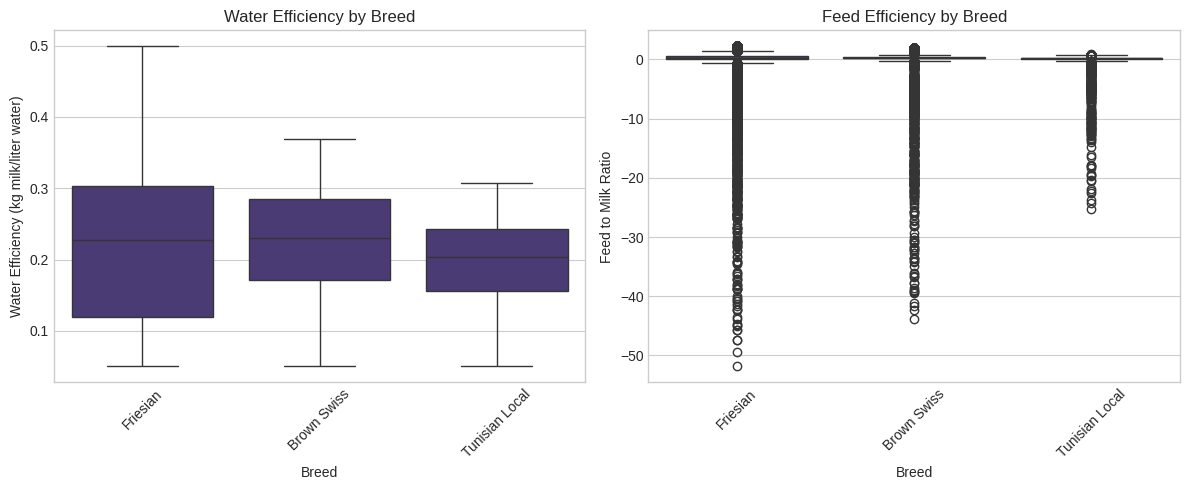

In [21]:
# Sustainability metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='breed', y='water_efficiency')
plt.title('Water Efficiency by Breed')
plt.xlabel('Breed')
plt.ylabel('Water Efficiency (kg milk/liter water)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='breed', y='feed_to_milk_ratio')
plt.title('Feed Efficiency by Breed')
plt.xlabel('Breed')
plt.ylabel('Feed to Milk Ratio')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Predictive Modeling

In this section, we'll develop predictive models for key dairy management metrics.
We'll create both regression models (for continuous variables like milk yield) and
classification models (for binary outcomes like mastitis).

In [ ]:
# Let's first define a function to prepare the data for modeling
def prepare_data_for_modeling(df, categorical_features, numerical_features, drop_features=None):
    """
    Prepare a dataset for machine learning by handling categorical and numerical features
    
    Parameters:
    df (DataFrame): The input dataframe
    categorical_features (list): List of categorical column names
    numerical_features (list): List of numerical column names
    drop_features (list): Features to drop from the data
    
    Returns:
    preprocessor: The column transformer for preprocessing
    """
    if drop_features:
        df = df.drop(columns=drop_features, errors='ignore')
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Define preprocessing for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor


def evaluate_regression_model(model, X_test, y_test, y_pred):
    """Evaluate regression model performance"""
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {type(model).__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return rmse, r2


def evaluate_classification_model(model, X_test, y_test, y_pred, y_pred_proba=None):
    """Evaluate classification model performance"""
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {type(model).__name__}')
    plt.show()
    
    # Plot ROC curve if probability estimates are available
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    
    return accuracy, precision, recall, f1

## Conclusions & Recommendations

Based on the analysis, here are key findings and recommendations for herd optimization:

1. **Productivity Optimization**:
   - Identify optimal feed composition for each breed based on milk yield and composition response
   - Focus on improving feed efficiency through breed selection and nutrition management

2. **Health Management**:
   - Implement preventive measures for mastitis based on SCC monitoring and risk factor analysis
   - Optimize cooling systems during high THI periods to reduce heat stress impacts

3. **Nutritional Strategy**:
   - Balance energy and protein in rations based on lactation stage for optimal production
   - Adjust fiber (NDF) levels to optimize milk fat content without compromising yield

4. **Environmental Management**:
   - Select housing and cooling systems that minimize mastitis risk while maximizing milk production
   - Implement climate adaptation strategies for maintaining productivity during heat stress

5. **Economic & Sustainability**:
   - Prioritize breeds with better feed and water efficiency to improve profitability
   - Consider environmental impact alongside economic performance in breeding and management decisions